In [1]:
import sys
sys.path.append('../src')
import numpy as np
from tqdm import tqdm
from scipy.special import erf, erfinv
import matplotlib.pyplot as plt
from models import *
from utils import *
from train_funcs import *
from visualization import *
rng = np.random.default_rng()

In [2]:
NE, NI, N_syl, N_HVC_per_syl = 600, 150, 1, 1
N_HVC = N_syl * N_HVC_per_syl

In [3]:
peak_rate, kernel_width = 150, 50

In [4]:
T_rend = kernel_width # Each rendition
N_rend = 100 # Number of renditions
T_burn = 500 # Burning
T = T_burn + N_rend * T_rend # Total

In [5]:
# Syllables and time stamps
# ( Number of syllables , Number of renditions )
_ = np.arange(0, T - T_burn + T_rend, T_rend) # start and end time of each rendition
# start and end time of each syllabus; inter-rendition interval = duration of a syllabus
_ = np.linspace(_[:-1], _[1:], num=N_syl+1, endpoint=True) + T_burn
tsyl_start, tsyl_end = _[:-1], _[1:]
tsyl_start, tsyl_end = np.round(tsyl_start), np.round(tsyl_end)

syl = rng.normal(1, 3, size=(N_syl, NE))#.clip(min=0)
syl_rand = syl.copy()
rng.shuffle(syl_rand, axis=1)
save_W_ts = np.round(tsyl_end[-1,:-1]).astype(int)

In [6]:
rH = np.zeros((T, N_HVC))
for i in range(N_HVC):
    bt = (tsyl_start[0] + i * kernel_width).astype(int)
    for b in bt:
        rH[b:b+kernel_width,i] = peak_rate

In [7]:
# (T, NE)
aud = generate_discrete_aud(T, NE, tsyl_start, tsyl_end, syl)
# aud[:T_burn] = rng.normal(0, 1, size=(T_burn, NE))

In [8]:
rEmax, rImax, thE, thI, sE, sI = 50, 100, -4, 0, 2, 2
phiE = lambda x: rEmax/2 * (1 + erf((x - thE) / (np.sqrt(2) * sE)))
phiI = lambda x: rImax/2 * (1 + erf((x - thI) / (np.sqrt(2) * sI)))

def quick_net(gamma, w0_mean, w_inh, 
              JEE0=0.22, JEI0=0.2, JIE0=0.4, JII0=0.3, wI=0, tauE=30, tauI=10):
    gen = lognormal_gen
    # gen = const_gen
    c = 1
    sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * gamma
    JEE = generate_matrix(NE, NE, gen, c, rng=rng, mean=JEE0, std=sEE) / np.sqrt(NE)
    JEI = generate_matrix(NE, NI, gen, c, rng=rng, mean=JEI0, std=sEI) / np.sqrt(NI)
    JIE = generate_matrix(NI, NE, gen, c, rng=rng, mean=JIE0, std=sIE) / np.sqrt(NE)
    JII = generate_matrix(NI, NI, gen, c, rng=rng, mean=JII0, std=sII) / np.sqrt(NI)

    net = EINet(NE, NI, N_HVC, w0_mean, phiE, phiI, tauE, tauI, w0_std=w0_mean/2,
                JEE=JEE, JEI=JEI, JIE=JIE, JII=JII, w_inh=w_inh, wI=wI)
    return net

In [9]:
plasticity_kwargs = dict(plasticity=dict(HVC=bilin_hebb_E_HVC), 
                         lr=dict(HVC=-2e-2), tauW=1e5, asyn_H=0, rE_th=1)
dt = 1
hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
hI0 = rng.normal(loc=-1, scale=0.5, size=NI)

In [10]:
w0_mean = 0.1/N_HVC
w_inh = w0_mean
net_fp = quick_net(0.1, w0_mean, w_inh)
net_lc = quick_net(1, w0_mean, w_inh)

In [11]:
train_fp = net_fp.sim(hE0, hI0, rH, aud, save_W_ts, T, dt, 0, **plasticity_kwargs)
train_lc = net_lc.sim(hE0, hI0, rH, aud, save_W_ts, T, dt, 0, **plasticity_kwargs)

100%|█████████████████████████████████████| 5499/5499 [00:01<00:00, 5198.85it/s]


In [12]:
correlation(train_fp[2]['HVC'][-1].T, syl, dim=2), correlation(train_lc[2]['HVC'][-1].T, syl, dim=2)

(array([[-0.99954253]]), array([[-0.8085686]]))

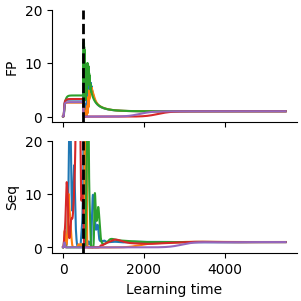

In [13]:
fig, ax = plt.subplots(2, 1, sharex='all', sharey='all', figsize=(3,3))
ax[0].plot(train_fp[0][:,:5])
ax[1].plot(train_lc[0][:,:5])
ax[0].axvline(T_burn, ls='--', c='k', lw=2)
ax[1].axvline(T_burn, ls='--', c='k', lw=2)
ax[0].set(ylim=[-1, 20], ylabel='FP')
ax[1].set(xlabel='Learning time', ylabel='Seq')
fig.savefig('../svg/supplementary/define_fp_and_seq.svg')

In [14]:
def tilde_phiE_dphiE(mu, sig2):
    s = np.sqrt(2 * (sE**2 + sig2))
    dphiE = rEmax/np.sqrt(np.pi)/s * np.exp(-(mu-thE)**2/s**2)
    phiE = rEmax/2 * (1 + erf((mu-thE)/s))
    return phiE, dphiE

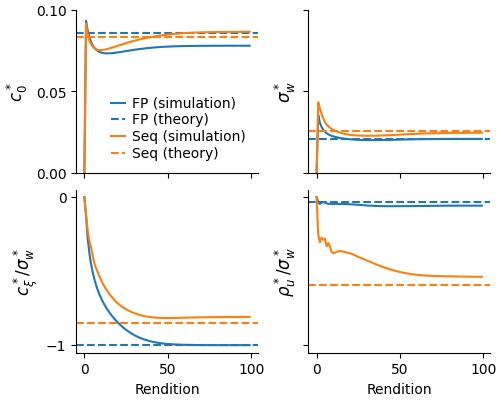

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(5, 4), sharex='all', sharey='row')

ti = int(tsyl_start[0,0]) # when to start

for k, (tr, l) in enumerate(zip((train_fp, train_lc), ('FP', 'Seq'))):
    c0_lhs = [0]
    sig_w_lhs = [0]
    corr_u_lhs = [0]
    corr_xi_lhs = [0]
    for i, W in enumerate(tr[2]['HVC'][1:]):
        # c0: W mean
        c0_lhs.append(W.mean())
        # sig_w: W std
        sig_w_lhs.append(W.std())
        # corr between W(t*) and (normalized) xi
        corr_xi_lhs.append(correlation(syl[0], W.T)[0])
        # corr between W(t*) and epsilon(t*)
        corr_u_lhs.append(correlation(tr[-1][save_W_ts[i]], W[:,0], dim=1))

    recE = tr[-1][save_W_ts[-1]] # recurrent input at t*
    # c0: W mean
    tp, dtp = tilde_phiE_dphiE(recE.mean(), recE.var())
    d0 = (1 - tp) / dtp
    c0_theory = (d0 - syl.mean()) / peak_rate + w_inh
    # sig_w: W std
    sig_w_theory = np.sqrt(recE.var() + syl.var()) / peak_rate
    # corr between W(t*) and (normalized) xi
    corr_xi_theory = -syl[0].std() /  sig_w_lhs[-1] / peak_rate
    # corr between W(t*) and epsilon(t*)
    corr_u_theory = (-recE.std() / sig_w_lhs[-1] / peak_rate).mean()
    
    color, l1, l2 = 'C%d' % k, l + ' (simulation)', l + ' (theory)'
    ax[0,0].plot(c0_lhs, c=color, label=l1)
    ax[0,0].axhline(c0_theory, c=color, ls='--', label=l2)
    ax[0,1].plot(sig_w_lhs, c=color, label=l1)
    ax[0,1].axhline(sig_w_theory, c=color, ls='--', label=l2)
    ax[1,0].plot(corr_xi_lhs, c=color, label=l1)
    ax[1,0].axhline(corr_xi_theory, c=color, ls='--', label=l2)
    ax[1,1].plot(corr_u_lhs, c=color, label=l1)
    ax[1,1].axhline(corr_u_theory, c=color, ls='--', label=l2)

ax[0,0].set(ylim=[0, 0.1], yticks=[0, 0.05, 0.1])
ax[1,0].set(xlabel='Rendition', yticks=[-1, 0])
ax[1,1].set(xlabel='Rendition')
ax[0,0].set_ylabel(r'$c^*_0$', fontsize=12)
ax[0,1].set_ylabel(r'$\sigma^*_w$', fontsize=12)
ax[1,0].set_ylabel(r'$c^*_\xi / \sigma^*_w$', fontsize=12)
ax[1,1].set_ylabel(r'$\rho^*_u / \sigma^*_w$', fontsize=12) 
ax[0,0].legend(labelspacing=0.2)
fig.savefig('../svg/supplementary/agree_with_theory.svg')

In [16]:
def perturb(net, Ws, axes, pert_vals, T_test=500, dt=1, disable_tqdm=False):
    '''
    Ws: list of weights
    axis: 1- or 2-tuple of axes of perturb, each must be NE-dimensional
    pert_vals: 1- or 2-tuple of perturbation values
    '''
    T_burn = T_test // 2

    rE = np.zeros((T_test, net.NE))
    rI = np.zeros((T_test, net.NI))
    rH = np.zeros((T_test, net.NH))
    aud = np.zeros((T_test, net.NE))
    rH[T_burn:,0] = peak_rate

    W_cur = net.W.copy() # backup W

    ret = np.zeros((len(Ws), len(pert_vals[0]), len(pert_vals[1]), 2))
    for i in range(len(Ws)):
        net.W = Ws[i] # update W

        for j in tqdm(range(len(pert_vals[0])), disable=disable_tqdm):
            for k in range(len(pert_vals[1])):
                aud[T_burn:] = syl.mean() + axes[0] * pert_vals[0][j] + axes[1] * pert_vals[1][k]
                
                rE *= 0
                rI *= 0
                hE, hI = 0, 0
                rE[0] = net.phiE(hE)
                rI[0] = net.phiI(hI)

                for t in range(1, T_test): # sim
                    aux = net.W @ rH[t-1] - net.w_inh * rH[t-1].sum()
                    recE = net.JEE @ rE[t-1] - net.JEI @ rI[t-1]
                    recI = net.JIE @ rE[t-1] - net.JII @ rI[t-1]
                    dE = -hE + aux + aud[t-1] + recE
                    dI = -hI + recI + net.wI * rH[t-1].mean()
                    hE += dE * dt / net.tauE
                    hI += dI * dt / net.tauI
                    rE[t], rI[t] = net.phiE(hE), net.phiI(hI)
                ret[i,j,k] = rE[-100:].mean(), rI[-100:].mean()
    net.W = W_cur # restore
    
    return ret

In [17]:
# the other axis is an arbitrary direction
axes = [rng.normal(syl.mean(), syl.std(), size=NE), syl[0].copy()]
for i in range(2):
    axes[i] = (axes[i] - axes[i].mean()) #/ np.linalg.norm(axes[i])
    # axes[i] = axes[i] / np.linalg.norm(axes[i])
pert_vals_rand = (np.linspace(-2.5, 2.5, num=11), np.linspace(-2.5, 3, num=11))
ret_rand = perturb(net_lc, [train_lc[2]['HVC'][i] for i in (0, 2, -1)], axes, pert_vals_rand)

100%|███████████████████████████████████████████| 11/11 [00:07<00:00,  1.44it/s]


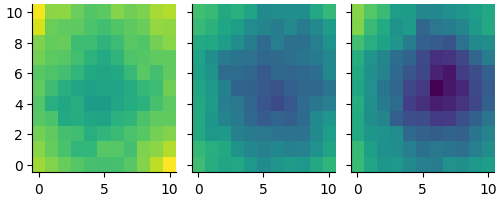

In [18]:
fig, ax = plt.subplots(1, ret_rand.shape[0], figsize=(5, 2), sharey='all', sharex='all')
for i in range(ret_rand.shape[0]):
    ax[i].imshow(ret_rand[i,...,0], aspect='auto', origin='lower', 
                 vmin=ret_rand[...,0].min(), vmax=ret_rand[...,0].max()) 

In [19]:
def plot_3d_response(pert_vals, ret_, ylabel, zmax, 
                     levels=(1, 2, 3, 4), figsize=(8,3)):
    fig, ax = plt.subplots(1, 4, subplot_kw={'projection': '3d'}, figsize=figsize, 
                           constrained_layout=True)
    ts_loc = 1 # or if the axis is normalized, np.linalg.norm(syl[0])
    ret = ret_.copy()
    ret[ret > zmax+0.5] = np.nan
    x, y = np.meshgrid(*pert_vals, indexing='ij') 
    for i, n in enumerate(('before', 'during', 'after', '')):
        j = i if i <= 2 else 2
        ax[i].view_init(elev=20, azim=45, roll=0)
        ax[i].plot_surface(x, y, ret[j,...,0], cmap='plasma', alpha=0.8, 
                           antialiased=False)
        ax[i].contour(x, y, ret[j,...,0], zdir='z', levels=levels, offset=0, 
                      cmap='plasma', zorder=-1)
        ax[i].scatter(0, ts_loc, zs=0, marker='o', s=40, color='r', alpha=0.8)
        ax[i].set(xticks=[], yticks=[], zticks=[], zlim=[0, zmax])
        if i <= 2: # subplot title
            ax[i].text(0, 0, zmax+2, n + ' learning', fontsize=11, ha='center')
        # Style setting 
        ax[i].set_box_aspect(aspect=None, zoom=0.95)
        ax[i].computed_zorder = False
        ax[i].grid(False)
        ax[i].xaxis.pane.fill = False
        ax[i].yaxis.pane.fill = False
        ax[i].zaxis.pane.fill = False
    ax[0].plot([0,x.min()], [ts_loc]*2, [0, 2], ls=':', c='r', lw=2)
    ax[0].text(x.min(), ts_loc, 2, 'tutor song', 
               color='r', ha='center', va='bottom')
    # plot trajectory
    init_coord = (np.array([x[0,-3], y[0,-3], ret[-1,0,-3,0]]) +\
                  np.array([x[1,-2], y[1,-2], ret[-1,1,-2,0]])) / 2
    if np.isnan(init_coord[2]):
        init_coord[2] = zmax
    ax[3].text(*(init_coord+[0,0,1]), 'immature\nsong', 
               color='navy', ha='center', va='bottom')
    ax[3].scatter(*init_coord, marker='o', s=40, color='navy')
    fig.text(0.0, 0.4, 'population\nresponse', ha='center', rotation=90)
    fig.text(0.06, 0.18, 'song\nvariation', ha='center', rotation=-25)
    fig.text(0.2, 0.35, ylabel, ha='center', va='top', rotation=22)
    return fig, ax

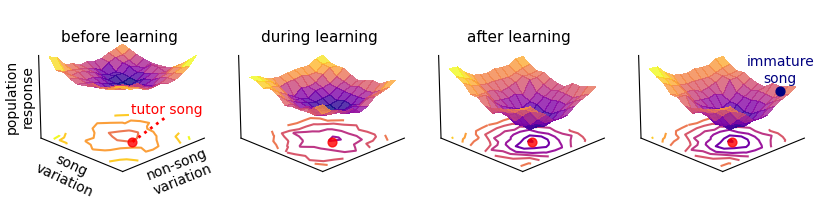

In [20]:
fig, ax = plot_3d_response(pert_vals_rand, ret_rand, 
                           ylabel='non-song\nvariation', 
                           zmax=ret_rand[...,0].max(),
                           levels=np.linspace(1, 12, num=10))
fig.savefig('../svg/landscape.svg', transparent=True)